# Fit CO2 concentration in atmosphere versus time

We first grab the CO2 data (I put them on the repo to avoid problems with the NOAA server...) and plot them, and try to fit them with different functions (polynomial and power law).

Data are at the address ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy
from scipy.optimize import curve_fit 

import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...

# We fix the random seed to always get the same problem
np.random.seed(seed=42)

# to deal with uncertainty propagation
import uncertainties
from uncertainties import unumpy as un

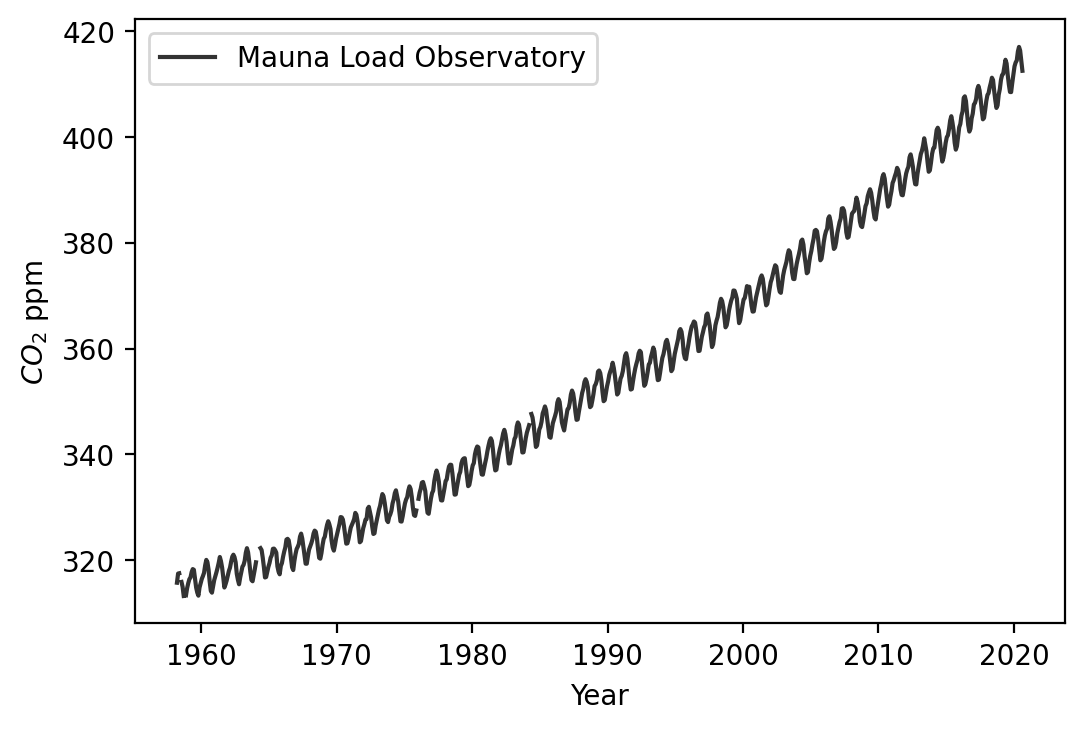

In [2]:
dat = pd.read_table('co2_mm_mlo.txt',
                  comment='#', sep='\s+', header=None, na_values=[-1, -99.99])

# what are the columns? 
dat.columns = ['year', 'month', 'dec_year', 'co2_av', 'co2_interp', 'co2_trend', 'days']

plt.figure(dpi=200)
# let's plot those data

plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

In [3]:
# let's make sure there is no NAN (missing values, happens in various geochemical records!)
dat.dropna(inplace=True)  # necessary because optimisation fails if there are NaNs in the data
x_fit = dat.loc[:, 'dec_year']
y_fit = dat.loc[:, 'co2_av']

# Fit it !

In [4]:
def forward_model(time, p0, p1, p2, p3, phase, amp):
    seasonal = un.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal


In [5]:
popt, pcov = curve_fit(forward_model,x_fit,y_fit)

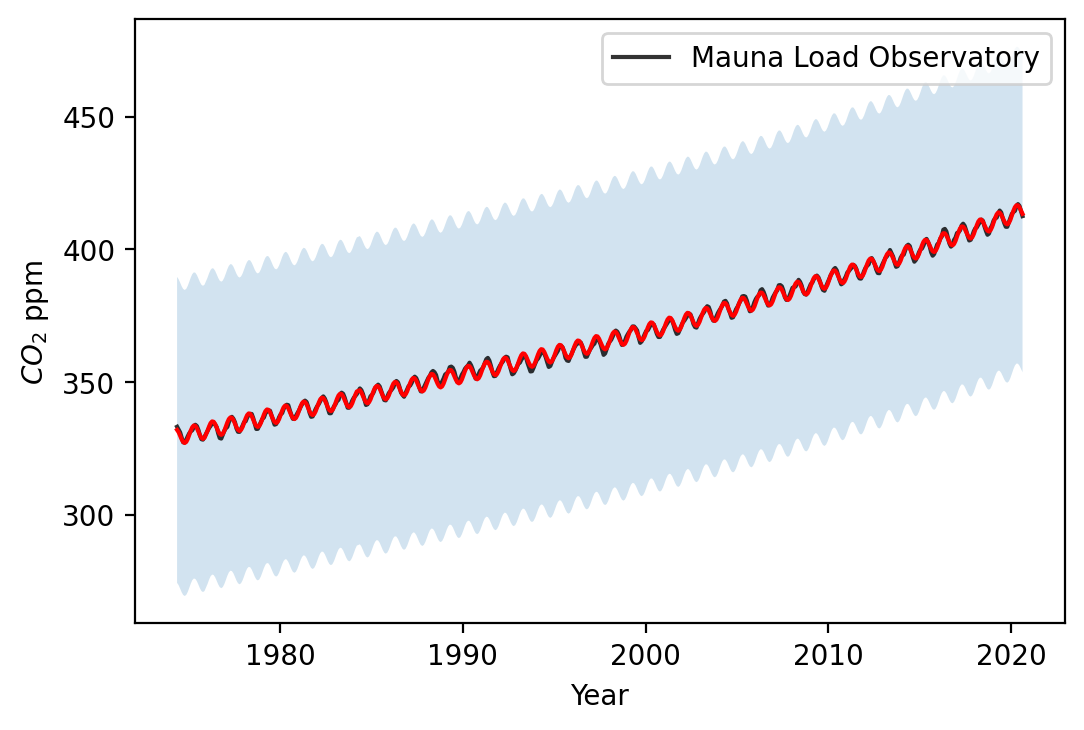

In [7]:
# after reading the docs, we see that we can create a 
# new params array with taking into account the covariance, and use if for error propagation.
params_2 = uncertainties.correlated_values(popt, pcov)
predictions_errors_2 = forward_model(x_fit,*params_2)

plt.figure(dpi=200)
# let's plot those data

plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')
plt.plot(x_fit, un.nominal_values(predictions_errors_2),"r-")
# plotting its error bars
plt.fill_between(x_fit, un.nominal_values(predictions_errors_2) - un.std_devs(predictions_errors_2),
                 un.nominal_values(predictions_errors_2) + un.std_devs(predictions_errors_2), alpha=0.2, zorder=-1)


plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()